In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf


In [2]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()

    return fix_df

In [3]:
# 读取数据
his_nmp_gf_df = pd.read_csv('.\\data\\GF001\\03 His_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_power_gf_df = pd.read_csv('.\\data\\GF001\\02 His_Power_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_gf_df=preprocessing(his_nmp_gf_df,his_power_gf_df)
his_gf_df.to_csv('his_gf.csv',encoding = 'utf-8') #存储合并后数据

In [4]:
df=pd.read_csv('his_gf.csv',parse_dates=["Datetime"],index_col=[0])
df.head()

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-13 00:00:00,0.0,6.9614,14.8148,27.32,998.67,92.59,0.0
2022-06-13 00:15:00,0.0,7.0349,15.1623,27.33,998.68,92.40,0.0
2022-06-13 00:30:00,0.0,7.1234,14.3874,27.31,998.54,92.42,0.0
2022-06-13 00:45:00,0.0,7.2816,15.6968,27.29,998.21,92.27,0.0
2022-06-13 01:00:00,0.0,7.2544,18.7347,27.34,997.92,91.92,0.0


In [5]:
df.tail()

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-19 22:45:00,0.0,8.8735,7.3813,27.97,997.04,91.88,0.0
2022-06-19 23:00:00,0.0,7.6355,357.8234,27.16,996.98,0.00,0.0
2022-06-19 23:15:00,0.0,7.0539,352.9153,27.19,997.26,0.00,0.0
2022-06-19 23:30:00,0.0,6.7206,350.5797,27.27,997.28,0.00,0.0
2022-06-19 23:45:00,0.0,7.0146,352.2164,27.27,996.74,0.00,0.0


In [6]:
df.shape

(672, 7)

In [7]:
# 划分train valid test集
gf_df_train = df[:int(0.6*len(df))]
gf_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
gf_df_test =df[int(0.8*len(df)):]

In [8]:
gf_df_train

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-13 00:00:00,0.0,6.9614,14.8148,27.32,998.67,92.59,0.0
2022-06-13 00:15:00,0.0,7.0349,15.1623,27.33,998.68,92.40,0.0
2022-06-13 00:30:00,0.0,7.1234,14.3874,27.31,998.54,92.42,0.0
2022-06-13 00:45:00,0.0,7.2816,15.6968,27.29,998.21,92.27,0.0
2022-06-13 01:00:00,0.0,7.2544,18.7347,27.34,997.92,91.92,0.0
...,...,...,...,...,...,...,...
2022-06-17 03:30:00,0.0,6.4324,19.0546,27.67,998.19,90.43,0.0
2022-06-17 03:45:00,0.0,6.4961,19.3275,27.65,998.17,90.19,0.0
2022-06-17 04:00:00,0.0,6.4812,19.7490,27.62,998.24,90.29,0.0


In [9]:
# # 划分train valid test集
# fd_df_train = df[:int(0.6*len(df))]
# fd_df_valid = df[int(0.8*len(df)):]
# fd_df_test =df[int(0.8*len(df)):]

In [10]:
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(gf_df_train)
df_for_validing_scaled=scaler.transform(gf_df_valid)
df_for_testing_scaled=scaler.transform(gf_df_test)

In [11]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

In [12]:
df_X,df_y=createXY(np.array(df))

In [13]:
train_X.shape

(396, 7, 7)

In [14]:
train_y.shape

(396,)

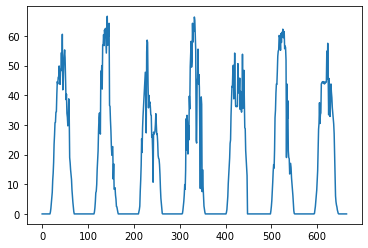

In [15]:
# 看一下历史波形
plt.plot(range(len(df_y)), df_y, label='history')

In [16]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=(abs(np.array(y_true) - np.array(y_predict.flatten()))).sum()
    return float(difference) 

In [17]:
# 建立模型函数
def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    
    return grid_model

In [18]:
# 准备一些copy用用
df_for_testing_scaled_1=df_for_testing_scaled.copy()
df_for_testing_scaled_inloop=df_for_testing_scaled.copy()
df_for_validing_scaled_inloop=df_for_validing_scaled.copy()
df_for_testing_scaled_1=pd.DataFrame(df_for_testing_scaled_1)
df_for_testing_scaled_inloop=pd.DataFrame(df_for_testing_scaled_inloop)
df_for_validing_scaled_inloop=pd.DataFrame(df_for_validing_scaled_inloop)

In [19]:
# df_for_testing_scaled_inloop.iloc[:,-1]=np.nan #这块是必要的，但是因为没做好所以暂时注释了

In [20]:
df_for_testing_scaled_inloop

,0,1,2,3,4,5,6
0,0.773231,0.833891,0.048671,0.875895,0.327068,0.837876,0.849433
1,0.824977,0.838103,0.046040,0.883055,0.300752,0.838377,0.841546
2,0.756666,0.844584,0.044505,0.866348,0.280075,0.840281,0.778209
3,0.703269,0.851671,0.041993,0.849642,0.263158,0.844890,0.285127
4,0.683247,0.858074,0.038985,0.842482,0.246241,0.848096,0.657369
...,...,...,...,...,...,...,...
130,0.000000,0.876112,0.015770,0.572792,0.261278,0.920641,0.000000
131,0.000000,0.737061,1.000000,0.379475,0.250000,0.000000,0.000000
132,0.000000,0.671736,0.986215,0.386635,0.302632,0.000000,0.000000
133,0.000000,0.634300,0.979656,0.405728,0.306391,0.000000,0.000000


In [21]:
df_7pieces_from_valid=df_for_validing_scaled_inloop.iloc[-7:,:]
df_7pieces_from_valid

,0,1,2,3,4,5,6
127,0.840042,0.846887,0.069815,0.902148,0.560150,0.825852,0.918715
128,0.689105,0.842405,0.068305,0.863962,0.530075,0.831964,0.895049
129,0.623149,0.842113,0.066037,0.842482,0.496241,0.838377,0.934606
130,0.556654,0.844269,0.065040,0.818616,0.460526,0.842886,0.891049
131,0.631982,0.846010,0.063877,0.835322,0.422932,0.843287,0.904881
132,0.740159,0.840305,0.060811,0.866348,0.389098,0.838076,0.922716
133,0.727085,0.834958,0.054654,0.871122,0.357143,0.835271,0.835601


In [22]:
full_df_test=df_7pieces_from_valid.append(df_for_testing_scaled_inloop)
full_df_test

C:\Users\23966\AppData\Local\Temp\ipykernel_9364\1155265752.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df_test=df_7pieces_from_valid.append(df_for_testing_scaled_inloop)


,0,1,2,3,4,5,6
127,0.840042,0.846887,0.069815,0.902148,0.560150,0.825852,0.918715
128,0.689105,0.842405,0.068305,0.863962,0.530075,0.831964,0.895049
129,0.623149,0.842113,0.066037,0.842482,0.496241,0.838377,0.934606
130,0.556654,0.844269,0.065040,0.818616,0.460526,0.842886,0.891049
131,0.631982,0.846010,0.063877,0.835322,0.422932,0.843287,0.904881
...,...,...,...,...,...,...,...
130,0.000000,0.876112,0.015770,0.572792,0.261278,0.920641,0.000000
131,0.000000,0.737061,1.000000,0.379475,0.250000,0.000000,0.000000
132,0.000000,0.671736,0.986215,0.386635,0.302632,0.000000,0.000000
133,0.000000,0.634300,0.979656,0.405728,0.306391,0.000000,0.000000


In [23]:
# 上面几步是为了让test真正实现feature预测，但是没做完

In [24]:
df_for_testing_scaled_1_array=df_for_testing_scaled_1.values
df_for_testing_scaled_inloop_array=df_for_testing_scaled_inloop.values

In [25]:
# 为循环初始化一些数据
bestscore=1000
flag=0
num=0
best_size=0
best_batch_size=0
best_epochs=0
time_step=7


In [26]:
df_for_testing_scaled_inloop_array

array([[7.73231022e-01, 8.33891185e-01, 4.86708452e-02, 8.75894988e-01,
        3.27067669e-01, 8.37875752e-01, 8.49433476e-01],
       [8.24976570e-01, 8.38103154e-01, 4.60395257e-02, 8.83054893e-01,
        3.00751880e-01, 8.38376754e-01, 8.41545794e-01],
       [7.56665886e-01, 8.44583970e-01, 4.45049404e-02, 8.66348449e-01,
        2.80075188e-01, 8.40280561e-01, 7.78208815e-01],
       [7.03268510e-01, 8.51671309e-01, 4.19932646e-02, 8.49642005e-01,
        2.63157895e-01, 8.44889780e-01, 2.85126663e-01],
       [6.83247423e-01, 8.58073502e-01, 3.89853201e-02, 8.42482100e-01,
        2.46240602e-01, 8.48096192e-01, 6.57368862e-01],
       [6.83423149e-01, 8.71102525e-01, 3.63172087e-02, 8.40095465e-01,
        2.31203008e-01, 8.49699399e-01, 4.81193623e-01],
       [6.30459231e-01, 8.97463833e-01, 3.39439938e-02, 8.25775656e-01,
        2.14285714e-01, 8.51503006e-01, 5.72195995e-01],
       [4.23535614e-01, 9.25128044e-01, 3.16516649e-02, 7.68496420e-01,
        1.93609023e-01, 8

In [27]:
# 开始循环（warning不影响做）
for size in [32]:
    for batch_size in [16]:
        for epochs in [30,40,50,60]:
            grid_model=build_model(size)
            grid_model.fit(
            train_X, train_y,
            validation_data=(valid_X, valid_y),
            batch_size=32,
            epochs=epochs,
            verbose=0)
            all_data_test=[]
# 此处用了和feature一样的逐点预测方法
            for i in range (time_step,len(df_for_testing_scaled_inloop_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_inloop_array[i-time_step :i , 0:df_for_testing_scaled_inloop.shape[1]])
                 data_x=np.array(data_x)
                 prediction=grid_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_inloop.iloc[i,-1]=prediction
            score=ev(test_y,np.array(all_data_test))
            print('num:',num,'score=',score,'size=',size,'batch_size=',batch_size,'epochs=',epochs,)
            num=num+1
            if score<bestscore:
                flag=1
                bestscore=score
                print(bestscore)
                best_size=size
                best_batch_size=batch_size
                best_epochs=epochs
                # Export the model to a SavedModel
                grid_model.save('keras_model_tf_version', save_format='tf')
print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)

C:\Users\23966\AppData\Local\Temp\ipykernel_9364\3105071880.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(test_y,np.array(all_data_test))


num: 0 score= 20.117198944091797 size= 32 batch_size= 16 epochs= 30
20.117198944091797


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


num: 1 score= 18.626555118344175 size= 32 batch_size= 16 epochs= 40
18.626555118344175


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


num: 2 score= 47.68169319377327 size= 32 batch_size= 16 epochs= 50


C:\Users\23966\AppData\Local\Temp\ipykernel_9364\3105071880.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(test_y,np.array(all_data_test))


num: 3 score= 6.314478874206543 size= 32 batch_size= 16 epochs= 60
6.314478874206543


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


6.314478874206543 best_size= 32 best_batch_size= 16 best_epochs= 60


In [28]:
# 加载最佳模型
my_model = tf.keras.models.load_model('keras_model_tf_version')

In [31]:
# 用最佳模型预测一下test
all_data_test=[]
for i in range (time_step,len(df_for_testing_scaled_1_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_1_array[i-time_step :i , 0:df_for_testing_scaled_1.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_1.iloc[i,-1]=prediction

In [32]:
ev(test_y,np.array(all_data_test))

C:\Users\23966\AppData\Local\Temp\ipykernel_9364\4268011167.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ev(test_y,np.array(all_data_test))


6.314478874206543

C:\Users\23966\.conda\envs\notebook\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


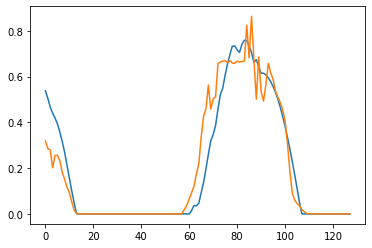

In [33]:
# 看看test的结果
plt.plot(range(len(all_data_test)), all_data_test, label='Prediction')
plt.plot(range(len(test_y)), test_y, label='Prediction')

In [34]:
# Recreate the exact same model
new_pred_valid_y=my_model.predict(valid_X)
ev(valid_y,new_pred_valid_y)


4/4 [==============================] - 0s 3ms/step


6.576600789876915

4/4 [==============================] - 0s 2ms/step


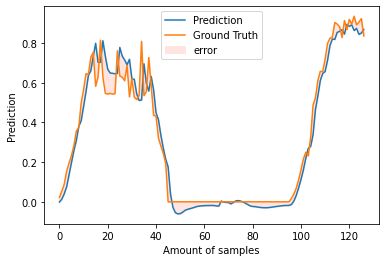

In [35]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [36]:
ev(valid_y,pred_valid_y)

6.576600789876915

In [37]:
# # %%
# # Predicting
# pred_y = my_model.predict(test_X)

In [38]:
# pred_y.flatten()

In [39]:
# # %% Plotting
# plt.plot(range(len(pred_y)), pred_y, label='Prediction')
# plt.plot(range(len(pred_y)), test_y, label='Ground Truth')
# plt.fill_between(range(len(pred_y)), pred_y.flatten(), test_y.flatten(), color='MistyRose',label='error')
# plt.xlabel('Amount of samples')
# plt.ylabel('Prediction')
# plt.legend()
# plt.show()
# # %%

In [40]:
# prediction of feature
df_30_days_past=gf_df_valid.iloc[-7:,:]
df_30_days_past.tail()

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-18 13:00:00,531.92,8.5708,25.2794,29.10,998.29,83.67,62.3017
2022-06-18 13:15:00,475.16,8.5900,24.9242,29.00,998.10,84.12,59.3981
2022-06-18 13:30:00,539.46,8.6055,24.5101,29.07,997.90,84.16,60.3202
2022-06-18 13:45:00,631.80,8.5547,23.4185,29.20,997.72,83.64,61.5091
2022-06-18 14:00:00,620.64,8.5071,21.2261,29.22,997.55,83.36,55.7019


In [41]:
df_30_days_future=pd.read_csv('.\\data\\GF001\\04 Fore_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
df_30_days_future["Power(MW)"]=0
df_30_days_future

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-07-15 00:00:00,0.0,4.7879,10.3477,27.89,990.79,89.94,0
2022-07-15 00:15:00,0.0,4.7817,10.6049,27.89,990.68,89.75,0
2022-07-15 00:30:00,0.0,4.7798,10.4871,27.88,990.51,89.62,0
2022-07-15 00:45:00,0.0,4.8969,7.0379,27.86,990.16,89.47,0
2022-07-15 01:00:00,0.0,5.1638,6.5607,27.85,989.78,89.30,0
...,...,...,...,...,...,...,...
2022-07-21 22:45:00,0.0,4.3397,40.7015,27.68,993.93,80.90,0
2022-07-21 23:00:00,0.0,4.4797,41.0175,27.65,994.44,0.00,0
2022-07-21 23:15:00,0.0,3.7592,38.3028,27.33,994.66,0.00,0


In [42]:
old_scaled_array=scaler.transform(df_30_days_past)

In [43]:
new_scaled_array=scaler.transform(df_30_days_future)

In [44]:
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,-1]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
full_df

,0,1,2,3,4,5,6
0,0.840042,0.846887,0.069815,0.902148,0.560150,0.825852,0.918715
1,0.689105,0.842405,0.068305,0.863962,0.530075,0.831964,0.895049
2,0.623149,0.842113,0.066037,0.842482,0.496241,0.838377,0.934606
3,0.556654,0.844269,0.065040,0.818616,0.460526,0.842886,0.891049
4,0.631982,0.846010,0.063877,0.835322,0.422932,0.843287,0.904881
...,...,...,...,...,...,...,...
674,0.000000,0.366879,0.109351,0.503580,-0.323308,0.810621,NaN
675,0.000000,0.382604,0.110238,0.496420,-0.227444,0.000000,NaN
676,0.000000,0.301678,0.102614,0.420048,-0.186090,0.000000,NaN
677,0.000000,0.307148,0.105861,0.431981,-0.223684,0.000000,NaN


In [46]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=7
for i in range(time_step,len(full_df_scaled_array)):
      data_x=[]
      data_x.append( full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
      data_x=np.array(data_x)
      prediction=grid_model.predict(data_x)
#       if prediction<0:
#             prediction=0
      all_data.append(prediction)
      full_df.iloc[i,-1]=prediction
#       print('?',full_df_scaled_array[i,-1])
#       print(full_df.values[i,-1])

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


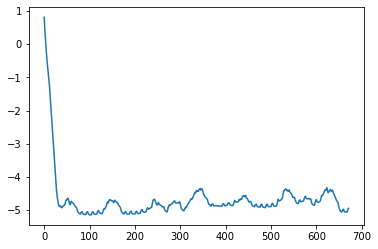

In [47]:
# 这是没有经过归一化逆变换的图
plt.plot(range(len(np.array(all_data).flatten())), np.array(all_data).flatten(), label='Prediction')

In [48]:
# # 这块地方涉及归一化的反变换，但是我感觉有点问题
# new_array=np.array(all_data)
# new_array=new_array.reshape(-1,1)
# prediction_copies_array = np.repeat(new_array,7, axis=-1)
# y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),7)))[:,0]
# print(y_pred_future_30_days)

In [49]:
# plt.plot(range(len(y_pred_future_30_days)), y_pred_future_30_days, label='Prediction')

In [50]:
# #绘制整体发电量图（反变换有点问题）
# total = np.hstack((df_y,y_pred_future_30_days))
# plt.plot(range(len(total)), total, label='Prediction',color='coral')
# plt.plot(range(len(df_y)), df_y, label='Prediction')

In [51]:
df_scaled=scaler.transform(df)

In [52]:
df_scaled_X,df_scaled_y=createXY(np.array(df_scaled))

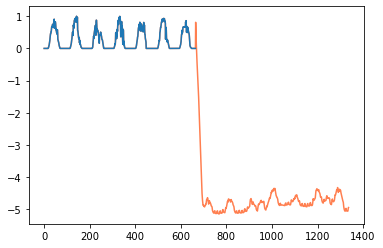

In [53]:
#绘制整体发电量图这个是未经过反变换的
#有点问题，是前面缺了点东西，
total = np.hstack((df_scaled_y,np.array(all_data).flatten()))
plt.plot(range(len(total)), total, label='Prediction',color='coral')
plt.plot(range(len(df_scaled_y)), df_scaled_y, label='Prediction')